# Make Fields

Take a domain with mandatory variables and generate the fields required to plot Betts fig 11 

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cftime
import matplotlib.pyplot as plt
import netCDF4 as nc


# Handy metpy tutorial working with xarray:
# https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html#sphx-glr-tutorials-xarray-tutorial-py
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.units import units
from metpy.plots import SkewT

In [2]:
data_in = xr.open_dataset("data/GFDL-ESM4-piControl", decode_times=False).metpy.quantify()
data_in['time'] = cftime.datetime.fromordinal(data_in.time, calendar='noleap') # manually reconvert to cftime

In [3]:
ps = 100000 * units.Pa # temporary hack, should interpolate pressure from daily timeseries (modify `get_domain`)


In [4]:
specific_humidity = data_in.huss#[np.isnan(data_in.huss.values) == False]#.metpy.quantify()
surface_temp = data_in.tas#[np.isnan(hourly_data.tas.values) == False].metpy.quantify()
data_in["td"] = mpcalc.dewpoint_from_specific_humidity(ps, data_in.tas, data_in.huss)


In [5]:
spatial_average = data_in.mean(dim=("lat", "lon"))
spatial_average.time.values # this is super wrong rn

array([cftime.DatetimeNoLeap(2399, 12, 29, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2399, 12, 30, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2400, 1, 1, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2495, 12, 24, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2495, 12, 26, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2495, 12, 28, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [6]:
# parse the whole dataset to comform to metpy norms, assign units to everything
#dparsed = data_in.metpy.parse_cf().metpy.quantify()
#dparsed


In [7]:
# need to add a step here to select only warm months with PBL development. could do:
# summer = my_ds.time[my_ds.time.dt.season == "JJA"]

# take spatial average over domain
#spatial_average = dparsed.mean(dim=("lat", "lon"))

In [8]:
# separate by soil moisture by rounding to nearest kg/m3 in top soil layer
spatial_average["soil_moisture_grp"] = spatial_average.mrsos.round()[np.isnan(spatial_average.mrsos.values) == False]


In [11]:
gbysoil = spatial_average.groupby(spatial_average.soil_moisture_grp)
gbysoil.groups.keys()

dict_keys([8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0])

In [12]:
gbysoil[8.0].time

<xarray.DataArray 'time' (time: 1763)>
array([cftime.DatetimeNoLeap(2422, 3, 12, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2422, 3, 15, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2422, 3, 18, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2458, 5, 23, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2458, 5, 26, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2458, 5, 29, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2422-03-12 12:00:00 ... 2458-05-29 12:00:00
    height   float64 2.0

IndexError: index 0 is out of bounds for axis 0 with size 0

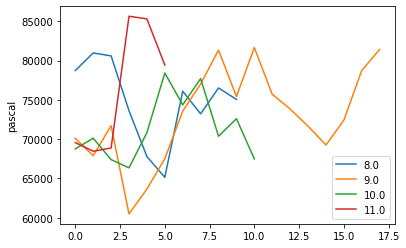

In [10]:
# calculate and plot the average diurnal cycle of lcl height

fig, ax = plt.subplots()
for key in gbysoil.groups.keys():
    # group by hour
    #hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.hour).mean(dim="time") 
    hourly_data = gbysoil[key].groupby(gbysoil[key].time.dt.year).mean(dim="time") 
    
    
    # find and plot the lcl
    plcl, tlcl = mpcalc.lcl(ps, hourly_data.tas, hourly_data.td)
    #print(plcl.magnitude)
    ax.plot(plcl[np.isnan(plcl) == False], label=key)
    ax.legend()   